In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import itertools
import warnings

In [2]:
df = pd.read_csv('data_for.csv')

In [3]:
df = df.interpolate(method='linear', axis=0)

/var/folders/95/yx09wtp16cv3j79pxwf94hlr0000gp/T/ipykernel_11395/2790185766.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear', axis=0)


In [9]:
# Transposing the dataframe to make rows represent months and columns represent categories
df_transposed = df.T

# The first row after transposition contains the categories, so we'll use it as column headers
df_transposed.columns = df_transposed.iloc[0]
df_transposed = df_transposed.drop(df_transposed.index[0])

# Resetting the index to make the 'Month/ Year' a column again
df_transposed.reset_index(inplace=True)
df_transposed.columns.name = None

# Renaming columns for clarity
df_transposed.rename(columns={'index': 'Month/Year', 'Shipped': 'Shipped'}, inplace=True)

# Removing commas from the 'Shipped' column and converting to float
df_transposed['Shipped'] = df_transposed['Shipped'].str.replace(',', '').astype(float)

# Converting 'Month/Year' to datetime format. Assuming the days to be the first of the month for simplicity.
df_transposed['Month/Year'] = pd.to_datetime(df_transposed['Month/Year'], format='%b-%y')

# Display the cleaned and formatted dataframe
df_transposed.head()


,Month/Year,NaN,Starting,Shipped,Production,Ending,NaN,NaN,NaN,NaN,NaN
0,2013-01-01,NaN,"120,816.00",26203.0,"31,258","125,871",NaN,NaN,NaN,NaN,NaN
1,2013-02-01,NaN,"125,871",33738.0,"28,281","120,415",NaN,NaN,NaN,NaN,NaN
2,2013-03-01,NaN,"120,415",18977.0,"31,258","132,696",NaN,NaN,NaN,NaN,NaN
3,2013-04-01,NaN,"132,696",40057.0,"32,747","125,386",NaN,NaN,NaN,NaN,NaN
4,2013-05-01,NaN,"125,386",33429.0,"32,240","124,197",NaN,NaN,NaN,NaN,NaN


In [10]:
# Selecting the 'Shipped' column and setting 'Month/Year' as the index
time_series = df_transposed.set_index('Month/Year')['Shipped']

# Interpolating missing values linearly, if any
time_series = time_series.interpolate(method='linear')

# Splitting the data into train and test sets (80% train, 20% test)
split_idx = int(len(time_series) * 0.8)
train_series = time_series[:split_idx]
test_series = time_series[split_idx:]

# Displaying the start of the train series to ensure it's ready for modeling
train_series.head(), test_series.head()

(Month/Year
 2013-01-01    26203.0
 2013-02-01    33738.0
 2013-03-01    18977.0
 2013-04-01    40057.0
 2013-05-01    33429.0
 Name: Shipped, dtype: float64,
 Month/Year
 2014-09-01    43675.0
 2014-10-01    31457.0
 2014-11-01    33346.0
 2014-12-01    23677.0
 2015-01-01    23677.0
 Name: Shipped, dtype: float64)

In [12]:
from statsmodels.tsa.arima.model import ARIMA
import itertools
import warnings

# Suppress warnings for model convergence issues during grid search
warnings.filterwarnings("ignore")

# Define the parameter range for p, d, q
p = d = q = range(0, 3)  # ARIMA parameters range
pdq_combinations = list(itertools.product(p, d, q))

# Initialize variables to store the best AIC and corresponding ARIMA parameters
best_aic = float("inf")
best_params = None

# Grid search for the best ARIMA parameters
for combination in pdq_combinations:
    try:
        model = ARIMA(train_series, order=combination)
        model_fit = model.fit()
        
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_params = combination
    except:
        continue

best_params, best_aic

((2, 2, 1), 405.05607216506894)

In [13]:
from sklearn.metrics import mean_squared_error

# Fit the ARIMA model with the best parameters
model = ARIMA(train_series, order=best_params)
model_fit = model.fit()

# Forecasting
forecast = model_fit.forecast(steps=len(test_series))

# Calculate MSE
mse = mean_squared_error(test_series, forecast)

mse, forecast.head()

(289926082.4391059,
 2014-09-01    34849.188739
 2014-10-01    17250.948064
 2014-11-01     8159.178721
 2014-12-01    25520.665622
 2015-01-01      608.656169
 Freq: MS, Name: predicted_mean, dtype: float64)

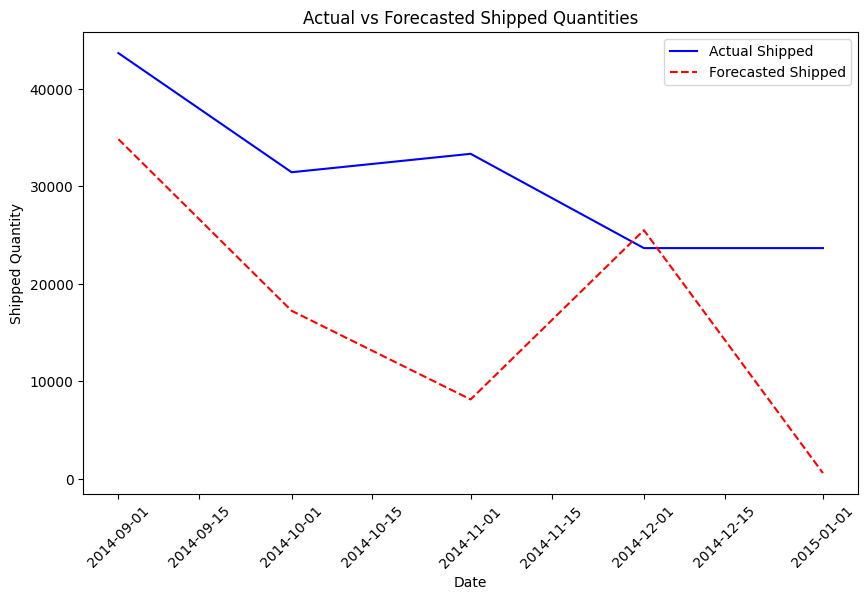

In [18]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(test_series.index, test_series, label='Actual Shipped', color='blue')
plt.plot(test_series.index, forecast[:len(test_series)], label='Forecasted Shipped', color='red', linestyle='--')
plt.title('Actual vs Forecasted Shipped Quantities')
plt.xlabel('Date')
plt.ylabel('Shipped Quantity')
plt.legend()
plt.xticks(rotation=45)
plt.show()